In [125]:
# %load ./include/header.py
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('./include')
import ml4s
import json
from jax import jacfwd
import jax.numpy as jnp
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('./include/notebook.mplstyle')
np.set_printoptions(linewidth=120)
ml4s._set_css_style('./include/bootstrap.css')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Part a
load the data from teh file and produce a plot of S vs.$\delta$

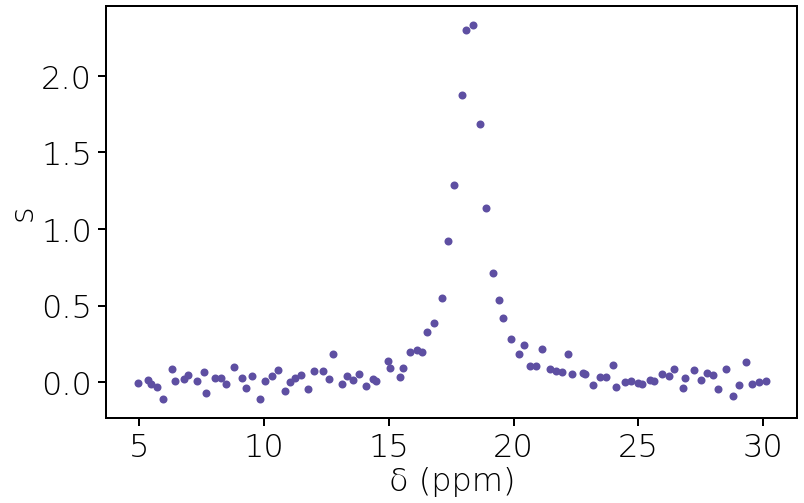

In [126]:
file_name = '../A02/C60_nmr.dat'
δ,S = np.loadtxt(file_name, unpack=True)
x=δ
y=S
plt.plot(δ,S, 'o', ms=3)
plt.xlabel('δ (ppm)')
plt.ylabel('s');

## Part b
Perform a least squares minimization via gradient descent in order to extract the optimal parameters $\alpha$ and $\beta$. These should be saved to disk in a C60_optimal.json file with the exact form (hint use indent=1 as an option to json.dump()):

{
"alpha": val,
"beta": val,
"num_iter": val,
"eta": val
}
    
where val are your calculated values, num_iter is the number of iterations, and eta is your
learning rate. This file should be submitted in your github repository and be locatable at the
path: netid/ml4s_HW/A02/C60_optimal.json.

## Note
The cost function is what we're trying to minimize
$$ C(\alpha,\beta) = \frac{1}{2N}\sum_{n=1}^N |S_{\rm model}(\delta^{(n)},\alpha,\beta)-S^{(n)}|^2 $$


In [127]:
def C(w,x,y):
    S=1/((x-w[0])**2+w[1])
    a=jnp.average((S-y)**2)
    return a

In [128]:
#function is cost func, C
dc_dw=jacfwd(C,argnums=0)

# hyperparameters
η = 0.5
γ = 0.9
v = np.zeros(2)
w = np.array([18.0,0.5])
num_iter = 50

for i in range(num_iter):
    # perform the NAG update
    v = γ*v + η*dc_dw(w-γ*v,x,y)
    w -= v
z=np.array(w)
α=z[0]
β=z[1]

In [129]:
data={
    "alpha": float(α) ,
    "beta": float(β) ,
    "num_iter": num_iter ,
    "eta": η
}
out_file = open("C60_optimal.json", 'w')
json.dump(data, out_file, indent=1)
out_file.close()

## Part c
Produce a final plot that includes the data, a curve of best fit. Use a legend to advertise the form of the fit function with your exacted parameter values.


In [130]:
def S_model(δ,α,β):
    S=1/((δ-α)**2+β)
    return S

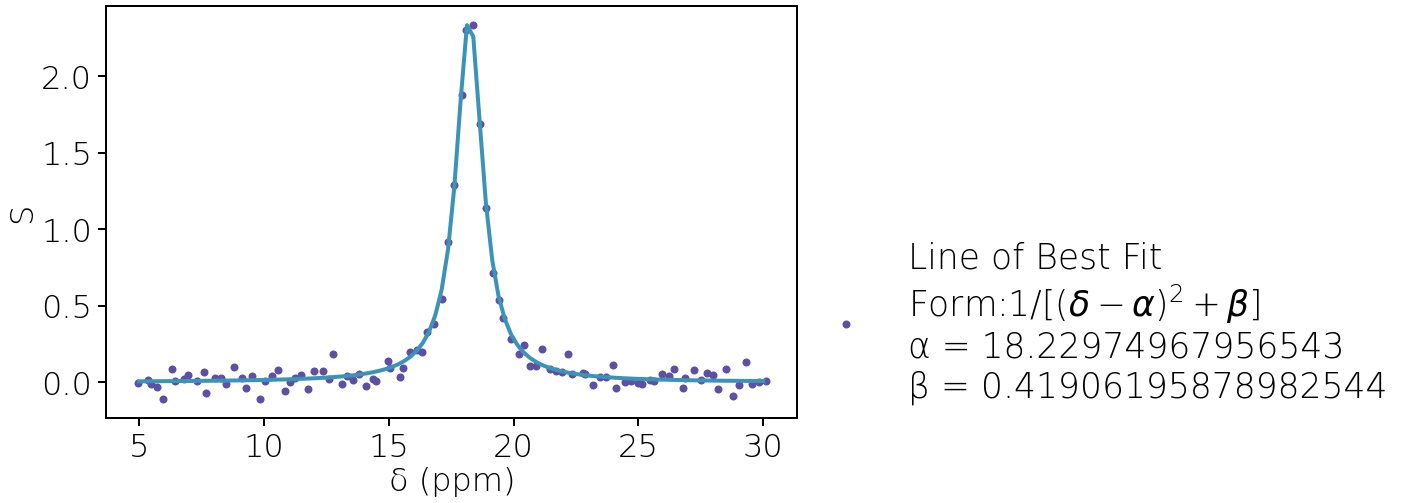

In [131]:
plt.plot(δ,S, 'o', ms=3)
plt.xlabel('δ (ppm)')
plt.ylabel('S');
δ_fit = np.linspace(5,30,100)
plt.plot(δ_fit, S_model(δ_fit,α,β))
plt.legend([f'Line of Best Fit\nForm:$1/[(δ-α)^2+β]$\nα = {α}\nβ = {β}'],fontsize=('xx-large'),loc=(1,0.0))

## Part d
Extract the optimal parameters using feature maps. You should append two
additional fields to your .json called alpha_fm and beta_fm. How do these parameters
compare to those you found in part (b)? Is the fit better or worse?

In [132]:
def S_fm(w,x):
    a=1/((x-w[0])**2+w[1])
    return 1/a

In [133]:
def C_fm(w,x,y):
    a=0.5*jnp.average((S_fm(w,x)-y)**2)
    return a

In [134]:
def yaxis(w,x):
    S=1/((x-w[0])**2+w[1])
    return S

In [135]:
x_fm=x[50:60]
y_fm=1/y[50:60]
w_fm=jnp.array([18.0,0.4])
η=0.25
num_iter=50
for i in range(num_iter):
    w_fm -= η*jacfwd(C_fm)(w_fm,x_fm,y_fm)

In [136]:
x_fit,y_fit = [],[]
x_fit = np.linspace(np.min(x),np.max(x),1000)
y_fit = yaxis(w,x_fit)
y_fit2 = yaxis(w_fm,x_fit)

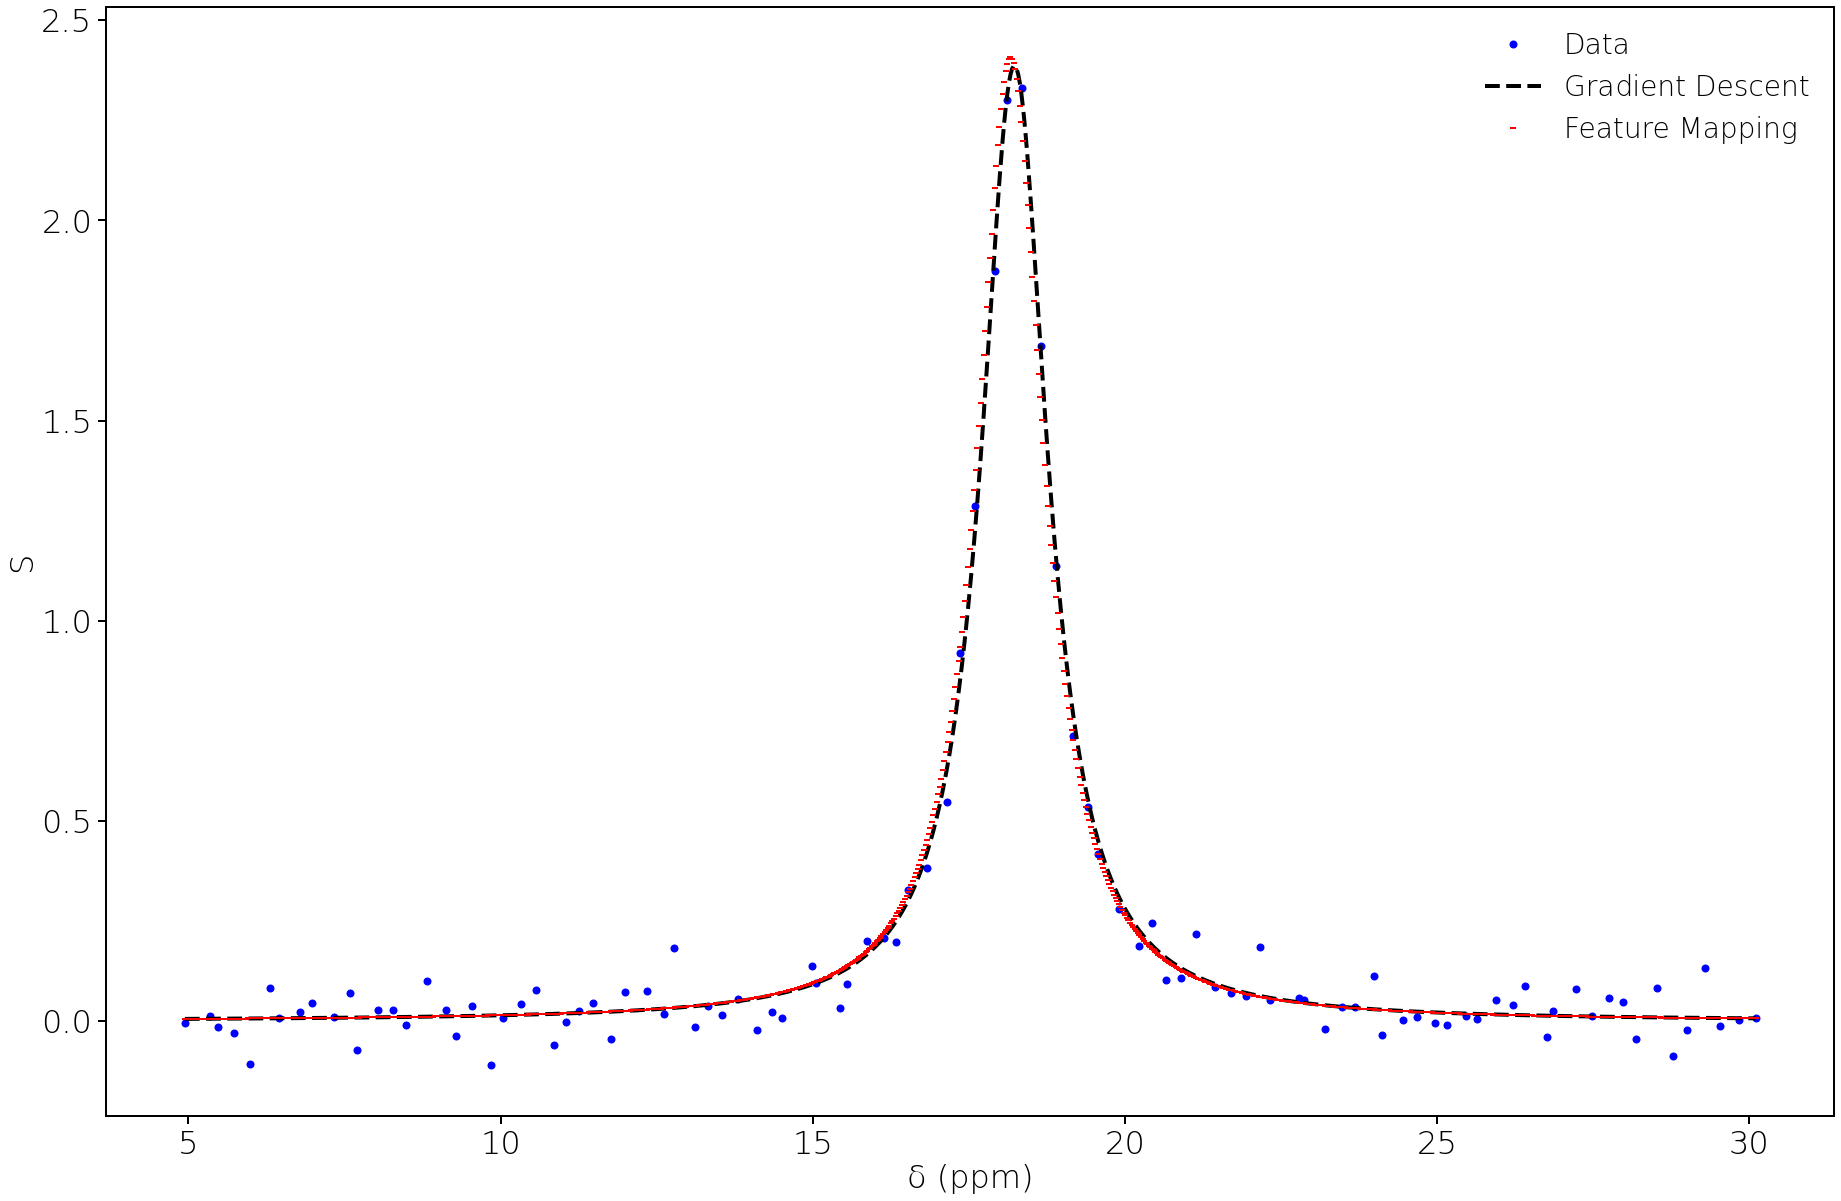

In [123]:
plt.figure(figsize=(15,10))
plt.plot(δ,S, 'bo', ms=3, label= "Data")
plt.plot(x_fit,y_fit,'k--', ms=2, label="Gradient Descent")
plt.plot(x_fit,y_fit2,'r_', ms=3, label="Feature Mapping")

plt.xlabel('δ (ppm)')
plt.ylabel('S');
plt.legend();

In [137]:
data['alpha_fm'] = float(w_fm[0])
data['beta_fm'] = float(w_fm[1])

out_file = open("C60_optimal.json", 'w')
json.dump(data, out_file, indent=1)
out_file.close()

## Comment:
Comparing the two methods to each other, it can bee seen that both are effective at producing the optimal values to fit the curve to the data. My preference is to use the gradient descent method with momentum. This method seemed to be more accurate in fewer iterations.